In [34]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict ,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score


sns.set()

In [35]:
titanic = pd.read_csv("train.csv")

In [36]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Do we have missing values?

In [37]:
titanic.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

### See what features are important

In [38]:
titanic.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


[Text(0, 0.5, 'Survival count')]

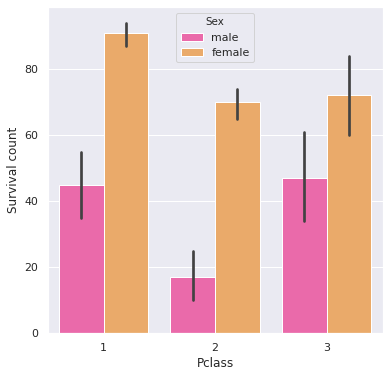

In [39]:
survived_count = titanic.Survived[titanic.Survived == 1].count()
dead_count = titanic.Survived[titanic.Survived == 0].count()

fig, ax = plt.subplots(figsize=(6,6))
sns.set_color_codes("pastel")
bp = sns.barplot(x="Pclass", y="Survived", data=titanic, color="b", hue="Sex", estimator=np.sum, palette="spring")
ax.set(ylabel="Survival count")
#plt.ylim(top=len(titanic.index))

In [40]:
# #ageclass = pd.cut(titanic.Age, bins=4, precision=0)
#titanic["Age"] = titanic.Age // 10 * 10
# #pt = titanic.pivot_table("Survived", index=["Sex", ageclass], columns=["Pclass"])
# pt = titanic.pivot_table("Survived", index=["Sex", "Age"], columns=["Pclass"])
# #ix = pt.index.to_frame(index=False)
# #pt.reset_index(level=0, inplace=True)

# #pt = pd.merge(ix, pt, left_on="Age", right_on="Age", left_index=False, right_index=False)
# pt_t = pt.T.fillna(0).reset_index().melt(id_vars="Pclass", value_name="avg_survived")
# #pt_t
# sns.catplot(data=pt_t, x="Age", y="avg_survived", hue="Sex")

In [45]:
# sns.catplot(data=pt_t, x="Age", y="avg_survived", hue="Pclass")
ageclass = pd.cut(titanic.Age, bins=4, precision=0)
titanic["ageclass"] = ageclass
sns.barplot(data=titanic, x="Sex", y="ageclass", hue="Sex", estimator=np.sum)

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U408'), dtype('<U408')) -> dtype('<U408')

---> for a first try include Sex, Pclass, Fare and Age

### What fill method for Age?

In [ ]:
sns.distplot(titanic.Age, norm_hist=False, kde=False)

mean seems good

In [ ]:
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

### Create training set, dev test set and pipelines

In [ ]:
titanic_labels = titanic.Survived
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_ix, test_ix in split.split(titanic, titanic["Pclass"]):
    strat_train = titanic.loc[train_ix]
    strat_train_labels = titanic.Survived[train_ix]
    strat_train.drop("Survived", axis=1, inplace=True)
    
    strat_test = titanic.loc[test_ix]
    strat_test.drop("Survived", axis=1, inplace=True)
    strat_test_labels = titanic.Survived[test_ix]

In [ ]:
cat_pipeline = make_pipeline(OneHotEncoder())
age_pipeline = make_pipeline(SimpleImputer(strategy="mean"))
fare_pipeline = make_pipeline(SimpleImputer(strategy="mean"))

#pipeline.fit(strat_train, strat_train_labels)
#attrs = ["Sex", "Age", "Pclass"]
#drop = ["Fare", "Age"]
cat_attrs = ["Sex"]
age_attr = ["Age"]
fare_attr = ["Fare"]

full_pipeline = ColumnTransformer([
    ("pass unprocessed", "passthrough", ["Pclass"]),
    ("cat pipeline", cat_pipeline, cat_attrs),
    ("age pipeline", age_pipeline, age_attr),
    ("fare pipeline", fare_pipeline, fare_attr)
], remainder="drop")

strat_train_prep = full_pipeline.fit_transform(strat_train, strat_train_labels)

### Since this is a binary classification problem a classifier looks good

In [ ]:
linreg = LinearRegression()
sgd_clf = SGDClassifier(random_state=42)
rnd_forest = RandomForestClassifier(random_state=42)
#mse = cross_val_score(sgd_clf, strat_train_prep, strat_train_labels, scoring="neg_mean_squared_error", cv=15)
acc = cross_val_score(sgd_clf, strat_train_prep, strat_train_labels, scoring="accuracy", cv=15)

#np.sqrt(-mse)
acc

In [ ]:
acc = cross_val_score(rnd_forest, strat_train_prep, strat_train_labels, scoring="accuracy", cv=15)

acc

In [ ]:
grid = [
    {"n_estimators" : [2, 5], "max_features" : [2, 3, 4]},
    {"bootstrap" : [False], "n_estimators" : [2, 5], "max_features" : [2, 3, 4]}
]

grid = [
    {"n_estimators" : [2, 5], "max_features" : [1]},
    {"bootstrap" : [False], "n_estimators" : [2, 5], "max_features" : [1]}
]

grid_search = GridSearchCV(rnd_forest, grid, cv = 15, scoring="accuracy", return_train_score=True)

grid_search.fit(strat_train_prep, strat_train_labels)

best_rnd_forest = grid_search.best_estimator_
strat_test_prep = full_pipeline.fit_transform(strat_test)
pred = best_rnd_forest.predict(strat_test_prep)
accuracy_score(strat_test_labels, pred)

In [ ]:
sgd_clf.fit(strat_train_prep, strat_train_labels)
pred = sgd_clf.predict(strat_test_prep)
accuracy_score(strat_test_labels, pred)

In [ ]:
pred = cross_val_predict(rnd_forest, strat_train_prep, strat_train_labels, cv=15)
conf_mat = confusion_matrix(strat_train_labels, pred)
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cmap=plt.cm.gray, cbar=False)

In [ ]:
scores = sgd_clf.decision_function(strat_train_prep)
pred = cross_val_predict(sgd_clf, strat_train_prep, strat_train_labels, cv=15)
accuracy_score(strat_train_labels, pred)
# p, r, thresh = precision_recall_curve(strat_train_labels, pred)

# plt.plot(thresh, p[:-1], "b--")
# plt.plot(thresh, r[:-1], "r--")

# scores > 0.8
precision_score(strat_train_labels, pred)

In [ ]:
test = pd.read_csv("test.csv")
test_prep = full_pipeline.fit_transform(test)
titanic_prep = full_pipeline.fit_transform(titanic)

#sgd_clf.fit(titanic_prep, titanic_labels)
#survival_pred = sgd_clf.predict(test_prep)

survival_pred = best_rnd_forest.predict(test_prep)

survival_pred = pd.DataFrame(survival_pred, columns=["Survived"])

id_survival = pd.concat([test.PassengerId, survival_pred], axis=1)
id_survival.set_index("PassengerId", inplace=True)
id_survival.to_csv("predicition.csv")
id_survival